[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aynetdia/Budget_Constrained_Bidding/blob/master/Tutorial.ipynb) 

# Setting up the notebook in Colab

In [ ]:
# Mount on GDrive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Cloning the repo (only when setting up for the first time)
%cd drive/MyDrive
!git clone https://github.com/aynetdia/budget_constrained_bidding.git

Here's a link to the dataset: https://drive.google.com/drive/folders/1YYyxGMDW0EuZA2BI-uR_2j60lpngKgy8?usp=sharing

In order to set up the dataset, you either have to download the linked folder containing the dataset and put it into `/budget_constrained_biddig/data/ipinyou/`, in case you choose to run the notebook locally, or add a GDrive shortcut (go to: Shared with me -> Right click on the dataset folder -> Add shortcut to Drive) and select the  same `/budget_constrained_biddig/data/ipinyou/` as a location to place the shortcut in, if you want to run the notebook in Colab.

Link to the Github repo: https://github.com/aynetdia/budget_constrained_bidding.git

If needed, all the package requirements are listed in the requirements_pip.txt (for pip envs) and requirements_conda.txt (for conda envs) files, contained inside the Github repo.

In [ ]:
# Go into the project folder and pull the last changes (do that every time before running the notebook)
# If executing after cloning the repo: %cd budget_constrained_bidding
%cd /content/drive/MyDrive/budget_constrained_bidding
!git pull

# Table of Contents

&emsp;&emsp;1. Introduction into the application domain

&emsp;&emsp;2. Methods

&emsp;&emsp;3. DRLB Framework

&emsp;&emsp;4. Description of the Data Set

&emsp;&emsp;5. DRLB Implementation

&emsp;&emsp;6. DRLB Results 

&emsp;&emsp;7. References

# 1. Introduction

Allocating budget efficiently is a problem that has received a lot of attention in marketing literature. Budget constrained bidding, as an automated bidding strategy and a common scenario in Real-Time Bidding (RTB), is an important concept in online display advertising. This tutorial addresses the problem of budget allocation in marketing context and presents a solution for budget constrained bidding problem, which leverages model-free reinforcement learning. The tutorial is based on the findings of Wu D., et al. (2018) presented in "Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising". It proposes a model-free deep reinforcement learning method to solve the budget constrained bidding problem in RBT display advertising.

In this tutorial, we first explain how real-time bidding works and what budget constrained bidding problem is. Then we introduce some basic concepts of Reinforcement Learning, Constrained Markov Decision Process and Deep Q-Networks. In the next section we explain the Deep Reinforcement Learning to Bid framework, followed by a brief description of the dataset and an explanation on the implementation of the algorithms. Lastly, we discuss the results.

    



## 1.1 Real-time bidding   


Real-time bidding is a trading mechanism for online display advertising. It is an auction and describes the mechanism of advertisers setting a bid price for every ad impression (i.e. the ad placement) in real-time (Liu et al. , 2019).  

Figure 1 illustrates the following process of RTB. An ad impression is created when a user visits an ad-supported site (e.g. webpage or mobile apps) which then triggers an auction. Then an ad requests is sent by the supply-side platform (SSP, such as a webpage) to the ad exchange (ADX, that publishes the bid requests to the DSPs and that also holds auctions to determine which campaign win the ad impression). Accordingly, the demand-side platform (DSP, i.e. the advertisers’ buying systems) generates different bid prices. A bid price is based on users features (e.g. region) and ad features (e.g. ad dimension) extracted from the data management platform (DMP) or the webpage itself. The ADX then determines the winning advertiser (Liu et al. , 2019). Solely the highest bidder wins the ad impression opportunity to display its ad on the webpage.   

According to the widely used second-price auction principal, the winning advertiser pays the second highest bid in the auction (Wu et al., 2018). This cost basically is defined as the market price (Zhang et al. , 2014). The second-price auction ensures that the bid price for each ad impression should be equal to its true value of an action (e.g. click-through-rate). 
A challenge is to capture those valuable ad impressions in real-time, which can be solved by an appropriate bidding strategy.



<p align="center">
<img src="https://drive.google.com/uc?export=view&id=14dbywvUp94LlXv3sjL1VpDCs10SuYLRN" />
</p>

<p align="center">
Fig. 1: RTB 
<p>  








## 1.2 Budget Constrained Bidding

Budget Constrained Bidding is an automated bidding strategy in RTB. It serves as a mechanism to address the typical optimization goal, where advertisers opt to maximize the total value of winning impressions under a certain budget constraint. Generally, an impression is the presence of an online advertisement on e.g. a browsing website. A winning impression value is associated with the expected outcome of an advertisement, e.g. a click on the ad or a conversion as user feedback.  

A bidding strategy is based on the evaluation of impressions on an ad campaign, e.g. by the predicted click-through rate (CTR) or calculated bid price for each impression.   
A campaign runs during a certain time period that captures $N$ impression opportunities in sequential order $i$. Considering the competition with other bidders in real-time and the impression value $v{_i}$ of an ad placement, an advertiser gives a bid $b{_i}$ and only wins the auction if $b{_i}$ is the highest bid (Wu D., et al., 2018). In this case the advertiser gets the opportunity to display the ad and and thus, wins the ad impression, which then induces costs $c{_i}$. An optimal bid in RTB with budget constraint B takes the from of:

$$ b{_i} = v{_i} / \lambda, $$

where $v{_i}$ denotes the impression value of an ad placement and $\lambda$ a scaling parameter mapping $v{_i}$ to the scale of the bid (Zhang W., et al., 2016). If $\lambda$ increases, then the bid price decreases. Hence, high constrained budget should cause the general bidding price level to be lower (Zhang W., et al., 2014).  

However, the optimal bidding strategy depends on the market competition, auction volume and campaign budget. Bidding strategies usually consider the bid decision by treating each ad impression independently, ignoring the impacts of the overall effectiveness of the campaign and the dynamics of the RTB environment. Since the market price (second highest bid price) is unknown during the budget constrained bidding in real-time bidding environment, developing an optimal bidding strategy is complex to derive but yet crucial for advertisers to maximize their budget cost efficiency of each ad campaign. Reinforcement Learning (RL) is a solution for the above problem.

 

## 1.3 Knapsack problem
	
The basic idea of the Knapsack problem is to find an optimal strategy under some constraints. For example, how to choose the most suitable items to be placed in the backpack in order to maximize the values of the items, given a limited total weight. Such problems can usually be solved recursively, i.e., by converting the original problem into an iterable subproblem, and then solving it optimally by dynamic programming methods. KP is decomposed into multiple P, each instance P’ in RL represents a P and will be described as [ state,action,reward ] (Reza R.A, Yingqian Z., Murat F. et al， 2020). Regarding our research subject, budget constrained bidding is basically a knapsack problem (Zhou Y., et al., 2008). In this paper, we will apply Reinforcement Learning to efficiently allocate given budget and try to gain maximum rewards.
  


<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1iUdccP4aFYMTZ8y9oSgO57-1G3mvyNR_" width=300 height=200 />
</p>



# 2. Methods

## 2.1 Introduction to Reinforcement Learning 


 
Reinforcement Learning (RL) is a tool to support sequential decision-making events and is a highly active research field of machine learning. It finds enormous application in e.g. real-time-bidding in advertisement auction.

In order to make the process more clear, we first explain some basic concept of RL as follows:

- Policy: the whole actions the learning agent has taken in a concrete period 

- Agent: the one who takes the action

- Environment: the place where the agent takes action and interacts with him

- Action: the move the agent makes to interact with the environment

- State: a situation in which the agent perceives 

- Reward: feedback of the agent’s action 	


RL is a solution for core control problems in which an agent sequentially interacts with an unknown environment to maximize its cumulative reward (Richard S. and Andrew G., 2018). It is a simulation of the human learning process in dynamic environments without any supervision. To find the best strategy of reward maximization, the agent continuously interacts with the environment and finds the optimal action under different states. Roughly speaking, the agent’s goal is to get as much reward as possible over the long run.

For instance, board game playing is a classical dynamic decision-making process. Players need to interact with their counterparts. It is a procedure filled with immediate rewards, intuitive judgments, and each action will generate an impact in the end. The cumulative reward will decide its win-or-failure (Richard S. and Andrew G., 2018).

In reality, such scenarios will consist of several problems that can be solved by a class of solution methods, but not all of them can achieve the rewards maximization objective. In the learning process of RL, each action the agent made, will generate some impact not only on the immediate reward but also on the future states. In other words, RL faces a dynamic decision-making problem, the agent will obtain continuous rewards and punishments in this learning process and modify its behaviors according to the environment's feedbacks and finally to maximize the cumulative reward.


And the following image illustrates how typically agents interact with their environments in RL-based models:
![Image 1: Reinforcement Learning Process](https://drive.google.com/uc?export=view&id=1y_z3Xg_QCsK9kkfV3tWhtqJNDmW4PrAJ) 
 <!--<img src="img/process_RL.png" width=600 height=600 /> -->

	



### 2.2 Markov Decision Process

The Markov Decision Process (MDP) is a popular mechanisms to model Reinforcement Learning problems. MDP (Sutton and Barto, 2014) provides a framework that is widely used for modeling the dynamic agent-environment interactions - as mentioned and depicted in figure 2.   

An MDP can be represented by a tuple (S, A, P, R), where S and A denotes sets of all states and all possible actions $a$ $\in$ $A$  in state $s$ $\in$ $S$, P represents the state transition probability from state $s$ $\in$ $S$ to another state $s^\prime$ $\in$ $S$ when taking action $a$ $\in$ $A$ that is denoted as $𝑇(𝑠,𝑎,𝑠^\prime)$ and R represents the reward function that is denoted as $r(a,s,s^\prime)$. Accordingly, in MDP the interaction process between the agent and its environment is summarized as the following: The agent observes state $s_t$ from the environment and takes action $a_t$ according to the policy strategy $\pi$ in each time step t∈T (Liu et al., 2019). In MDP the state transition $𝑇(𝑠,𝑎,𝑠^\prime)$ produces the probability $𝑃(𝑠^\prime | 𝑠,𝑎)$ to transition from state s into state $𝑠^\prime$ , given that the agent took action 𝑎. The environment then returns a reward $r_t$ to the agent. The rewards (numerical values) can be positive or negative based on the agents action (Sutton and Barto, 2014,  Liu et al., 2019). 
The agent then observes the next state and the process repeats. MDP will terminate after T time steps (e.g. after the budget is exhausted) since the time is limited.    


In MDP the policy $\pi$ is a mechanism to take decisions. Policies are defined by the action an agent takes on the current state (it does not depend on history) (Sutton and Barto, 2014). The agent uses the policy (see section 2.3) to interact with the environment by sequentially taking actions and to alter its behavior in order to maximize the cumulative reward 𝑅 (all the rewards that the agent receives from the environment) (Wu D., et al., 2018).  

Overall, the goal of the agent is to learn the optimal policy $\pi^*$ , which maximizes the long-term expected reward form the start state:
$$\pi^* = arg max_{\pi}  E [R | \pi],$$ where $R = \sum^T_{t=1} \gamma^{t-1} r_t $ denotes the cumulative discounted reward (Wu D., et al., 2018).    
  
Figure 3 illustrates the overall process of MDP.    
<p align="center">
<img src="https://drive.google.com/uc?export=view&id=15kJ_shivzm2VBhEMv7U952tHaa9WChfA" />
</p>

<p align="center">
Fig. 3: Markov decision process (Liu et al., 2019) 
<p>  


## 2.3 Bellman Equation for value functions


Reinforcement learning mostly involves estimating **value functions**, which are functions of states (quantifies the value of every state-action pair) (Sutton and Barto, 2014). It is used to estimate how good it is for the agent to be in a given state, i.e. how good (or bad) future rewards are that can be expected from experience (expected return). Since the expected return depends on the action that the agent will take, the value functions are defined respectively to particular policies. 
As mentioned earlier in section 2.2, MDPs aim to help the agent to find an optimal policy in its environment. Policies are defined by the action an agent takes on the current state. The objective of MDP policies is to maximize the expected return (reward from environment) for the agent. Thus, the policy $\pi$ of the value function defines the probability distribution of taking action a when in state s (Sutton and Barto, 2014), which essentially determines the behavior of an agent. For instance, this corresponds to the bidding strategy in RTB display advertising. If an agent follows a policy $\pi$ at time 𝑡 then $\pi(𝑎|𝑠)$ is the probability of that agent taking action 𝑎 at a particular time step 𝑡. The policy $\pi$ is defined as follows (Singh A., 2019):    
$$\pi: S \rightarrow P(A) .$$ 
So essentially, it is used to estimate how good an agent's actions $a$ $\in$ $A$ in a particular state $s$ $\in$ $S$ is.  


The **Bellman Equation for value function** $v_\pi$ expresses the relationship between the value of a state $s$ and the values of its successor states $s^\prime$ (Sutton and Barto, 2014). It helps to determine optimal policies and optimal value functions. 
The agent chooses the action according to the imposed policy. We know that policy changes with experience. Hence, different policies implies different value functions. 
The optimal value function is the one that gives the maximum value. So, we choose a sequence of action that will generate the highest reward which is the cumulative reward (referred to as Quality Value (Q-Value) in section 2.5). We will receive the highest Q-Value from $s^\prime$  by choosing the action that maximizes the Q-Value.   


So, the Bellman Equation is the expectation of reward the agent got on leaving the state $s$ plus the discounted value of the state $s^\prime$  the agent moved to. The Bellman Equation can be decomposed into the immediate reward, $R[t+1]$ , and the discounted value of successor states:

$$v_\pi(s)=E[R_{t+1} + \gamma v(S_{t+1}) | S{_t} = s].$$    

The discount factor $\gamma$ controls the importance of longterm rewards versus the immediate rewards. An immediate reward is yielded from being at state s and selecting action a. 
The value of a state, under an optimal policy, must equal the expected reward for the best action from that state (Sutton and Barto, 2014).     

Figure 4 depicts so called backup diagrams, that show the relationship of states which transfer value information back to a state form it’s successor state.   
<p align="center">
<img src="https://drive.google.com/uc?export=view&id=1fLbm9t-NHvMYjA5VJecwLjQizma7vOJV" />
</p>

<p align="center">
Fig. 4: Backup diagrams for value function (Sutton and Barto, 2014)  
</p>

## 2.4 Constrained Markov Decision Process  


Constrained Markov Decision Process (CMDP) (Altman E., 1999) extends the concept of MDP by adding additional constraints, e.g. a cost constraint. 

While learning in an unknown CMDP, an agent should trade-off exploration and exploitation. Accordingly, the agent explores to discover new information about the MDP, and exploits on the current knowledge to maximize the reward while satisfying the constraints.In an episodic CMDP the agent regulates $\lambda$ with a fixed time step T until the episode ends. The agent observes states and takes action to adjust $\lambda_{t-1}$ to $\lambda_{t}$ during each time step $t$. However, the agent will still converge to the suboptimal solution due to the immediate reward function (Wu D., et al., 2018).   
 
Note that the (C)MDP is often solve using model-based reinforcement learning approaches, where the state transition dynamics $T$ needs to be known in advance but is yet hard to predict, when considering the dynamic and unpredictable environment of an agent. Besides, model-based approaches suffer from the scalability problem, since calculations of state transitions matrices, which are then solved using dynamic programming algorithms, require high computational costs, which may be detrimential when deployed in real-world scenarios.

In contrast to this, model-free reinforcement learning approaches solves reinforcement learning tasks directly by solely using the policy function. Therefore, our focal paper proposes to use deep Q-Networks (DQN), which is a model-free RL approach. 



## 2.5 Deep Q-Networks  


Deep Q-Network (DQN) (Mnih, Kavukcuoglu, Silver et al., 2015) combines the methods of reinforcement learning and deep neural networks to map the environment states to the agents actions. DQN is a popular method of Q-learning. 

**Q-learning** algorithms (Watkins & Dayan, 1992) can be used when the probabilities of transitions are unknown and when the state or action spaces are large. It focus on learning a Q-Function that qualifies a state-action pair. So, the Q-Function tells us the value of performing a certain action or respectively how good it is for the agent to take action (a) in a state (s) with a policy $\pi$.
It iteratively computes the optimal value function, i.e. for each state s at each timestep t , the optimal value Q*(s,a,t) of each action a is estimated (Sutton and Barto, 2014).  

A Q-Value (Quality Value) represents the expected longterm reward of a Q-Learning algorithm under the assumption that the agent takes a perfect sequence of actions from a specific state. At any given state, we perform the action that will eventually yield the highest cumulative reward. This makes the algorithm greedy (Mnih, Kavukcuoglu, Silver et al., 2015). 

Essentially, Q-Learning utilizes the Bellman Equation. To estimate these state/action values, we can then update it using the Bellman Equation as an update rule (Watkins & Dayan, 1992):  
$$ Q(s,a) := r(s,a) + \gamma max_a Q(s^\prime, a)$$ 

As mentioned in section 2.3, it roughly states that the maximum future reward for a specific action, is the current reward plus the maximum reward for taking the next action.  


However, the main challenge of Q-Leraning and Bellman Equation is to the compute cost associated with estimating all combinations of state-action rewards, involving a large number of states. Thus, we approximate a Q-function instead of learning an exact Q-Function that evaluates all possible Q-Values. This is were DQN comes into play. 


**DQN** (Mnih, Kavukcuoglu, Silver et al., 2015) uses deep neural networks to approximate the Q-Function corresponding to the optimal policy without the need of handcrafting useful features. Recall that the goal of an agent is to select actions in order to maximize the cumulative reward. This cumulative reward that we receive is often referred to as the Q-Value. Thus, by utilizing deep neural networks we can estimate the Q-Value of all possible actions for a given state.  
The Q-Function $Q^*$ is defined as the maximum sum of rewards $r_{t}$ discounted by $\gamma$ at each tilmestep $t$. This is achieved by the behavior policy $\pi = P(a|s)$ of the agent. It defines the value of taking action $a$ in state $s$ under policy $\pi$:

$$ Q^*(s,a) = max_\pi E[r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ... | s_t=s , a_t=a, \pi ].$$  


In DQN the parameter $\epsilon$ of the $\epsilon$-greedy mechanism controls the proportion of exploration and exploitation, where $\epsilon$ is bounded at 0 < $\epsilon$ < 1. The exploitation describes that the agent finds his following action by maximizing the Q-value over all possible actions for the given state.The agent has the change to explore new opportunities.   


All in all, the agent uses deep neural networks to determine its actions and to train the neural network in such a way that it predicts the weighted, cumulative rewards of all actions. In DQN the agent learns the optimal policy by interacting directly with the workflow environment and also with the policies of other agents.


## 2.6 ML paradigm comparison	



Besides RL, supervised learning and unsupervised learning are the most classic machine learning methods. In this section, we explain why RL is the best choice for solving dynamic decision-making problems. Thus, the core differences among these three methods are shown in table below.


 ![Table 1: Machine Learning Methods Comparison](https://drive.google.com/uc?export=view&id=1U8oQjgdYPhFZ-FMyuyF2MPYSIuXksVkq) 
<!--<img src="img/methods_comparison.png" width=600 height=600 />-->

Supervised learning is mainly used to solve regression and classification problems. It explores the relation among labeled, the target variable, and other input variables and produces a model to predict further category identification.

In comparison, unsupervised learning obtains unlabeled observations and searches the hidden structure behind the input data. Both of these methods are not suitable for the desired behavior optimization problem in a dynamic process. Unlike supervised and unsupervised learning, which will not consider the capacity or some constrained environments, reinforcement learning will start with a clear initial setting, goal, and interactive agent. All the sequential action the agent takes will generate some influence in this environment. After a dynamic model training process, the agent obtains more and more rewards as desired by taking optimal actions in order to maximize the cumulative reward. 

Reinforcement Learning models heavily lean on the concept of a Markov Decision Process, which is used to formulate a given problem and thus find an optimal solution. Generally, when we can map our problems into an MDP, we can expect that reinforcement learning can be a useful tool to solve such problems. In the next section, we will explain the details behind Markov Decision Processes and how they are constructed, and give more details about Deep Reinforcement Learning to Bid, which is the main focus in our project.


# 3. Deep Reinforcement Learning to Bid (DRLB)

To address the problem of budget constrained bidding in real-time advertisement, Wu et al. (2018) proposed a framework that is built on top of DQN - Deep Reinforcement Learning to Bid (DRLB). The advantage of this framework for RTB is given by the fact that it is a model-free RL approach.

Thus, Wu et al. proposed training a **DQN agent** that sequentially regulates the bidding parameter $\lambda$ (remember, the bid in DRLB takes form of $b_i = v_i/{\lambda}$) instead of directly producing bids, which is the case in model-based approaches like the one introduced by Cai et al. (2017). Furthermore, instead of using the immediate reward from the environment to determine an optimal policy, an additional deep neural network (called **RewardNet**) is trained simultaneously with the DQN to predict the reward. Wu et al. (2018) found that simply using the immediate reward will make the agent obsessed with taking actions to agressively decrease $\lambda$ from the get ho to gain more immediate reward at each step and thus effectively neglect the budget constraint.

Additionally an **adaptive $\epsilon$-greedy policy**, that adjusts the exploration probability based on how the state-action value is distributed, was designed for DRLB. Hence the agent chooses action (adjusting the $\lambda$ parameter):

$$ a^* = argmax_a Q(s,a) $$

with probability $1 -\epsilon$ or otherwise takes a random action. $\epsilon$ is usually initialized with a large value and then gradually annealed to a small value over time. This balances the exploration-exploitation trade-off during training, by encouraging the agent to take more random actions in the beginning of the training process (and thus explore a variety of actions), and rely on the learned DQN parameters (exploit them) further down the training process. 

Before delving more into details of DRLB implementation, we'll describe the dataset that was used to train and evaluate the DRLB.

# 4. Description of the Data Set

This section gives a brief insight into the data structure and depicts the results of some explanatory data analysis (EDA) to provide a better understanding of the data.    

The datasets are provided by the Demand-Side Plateform (DSP) iPinYou Information Technologies Co., Ltd which is an established leading provider for audience-based programmatic adverting technology and builds RTB technology and algorithms. We examine the dataset of the advertiser with the advertiser ID "1458" that operates in the chinese vertical e-commerce industry. 

The data sets are split into train and test sets according according to Zhang et al. (2014), using their [Github repository](https://github.com/wnzhang/make-ipinyou-data), which is considered a benchmark format of the iPinYou dataset and also used for training and evaluating the DRLB framework. For the train set the first seven days are used for training, while for the test dataset the last three days are used for evaluation. Hence, in total the datasets comprise tracked performance from ten continous days.

Both data sets generally record the auction price (i.e. paying and bidding price), user feedback (i.e click, conversion, impression) and ad features (e.g. ad slot ID, width, height, visibility, floor price). In this dataset we deal with the **second price auction**, which means that the varaible *payprice*, representing the highest bid of "opponents" bidding simuiltaneously on a given ad placement, determines how much in the end will be paid for the bid request.

Another important aspect is that we slightly modified each dataset by including additional variables, in accordance with Wu et al (2018). We added the predicted click-trough-rate (pCTR) and time intervals for every quarter of an hour in minutes (min). The pCTR is used as an indicator of the impression value (i.e. how much is a given ad placement worth - the higher the probability of the click, the more it is worth to the advertiser), which is a second parameter ($v_i$) used to calculate the bid amount for a given ad placement, as explained in the introduction. Each 15 min interval represents a time step in the DRLB framework.

As for the variable pCTR, we applied a logistic regression to predict the CTR based on the features of the train set and clicks as our target variable.  

In [ ]:
#you should find yourself inside the project folder after you've pulled the latest changes
!ls

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load datasets
df_bid_train = pd.read_csv('data/ipinyou/1458/train.log.txt', sep="\t") 
df_bid_test = pd.read_csv('data/ipinyou/1458/test.log.txt', sep="\t") 

In [9]:
# This is an overiew of the fratures in the training data
df_bid_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3083056 entries, 0 to 3083055
Data columns (total 29 columns):
 #   Column          Dtype  
---  ------          -----  
 0   click           int64  
 1   pCTR            float64
 2   weekday         int64  
 3   hour            int64  
 4   min             int64  
 5   bidid           object 
 6   timestamp       int64  
 7   logtype         int64  
 8   ipinyouid       object 
 9   useragent       object 
 10  IP              object 
 11  region          int64  
 12  city            int64  
 13  adexchange      int64  
 14  domain          object 
 15  url             object 
 16  urlid           float64
 17  slotid          object 
 18  slotwidth       int64  
 19  slotheight      int64  
 20  slotvisibility  int64  
 21  slotformat      int64  
 22  slotprice       int64  
 23  creative        object 
 24  bidprice        int64  
 25  payprice        int64  
 26  keypage         object 
 27  advertiser      int64  
 28  usertag     

In [12]:
# View dimension and missing values of the train set
#print(df_bid_train.columns)
print('Dimensionality of the train data is {}'.format(df_bid_train.shape)) 
print('The data set has {} cases.'.format(df_bid_train.shape[0]))    
print('The total number of elements is {}.'.format(df_bid_train.size))
print('The total numbers of missing values of each variable in train data are \n{}.'.format(df_bid_train.isna().sum()))

Dimensionality of the train data is (3083056, 29)
The data set has 3083056 cases.
The total number of elements is 89408624.
The total numbers of missing values of each variable in train data are 
click                   0
pCTR                    0
weekday                 0
hour                    0
min                     0
bidid                   0
timestamp               0
logtype                 0
ipinyouid               0
useragent               0
IP                      0
region                  0
city                    0
adexchange              0
domain             169140
url                 68566
urlid             3083056
slotid                  0
slotwidth               0
slotheight              0
slotvisibility          0
slotformat              0
slotprice               0
creative                0
bidprice                0
payprice                0
keypage                 0
advertiser              0
usertag            399463
dtype: int64.


In [8]:
#'This is the feature description of the test data.'
df_bid_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614638 entries, 0 to 614637
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   click           614638 non-null  int64  
 1   pCTR            614638 non-null  float64
 2   weekday         614638 non-null  int64  
 3   hour            614638 non-null  int64  
 4   min             614638 non-null  int64  
 5   bidid           614638 non-null  object 
 6   timestamp       614638 non-null  int64  
 7   logtype         614638 non-null  int64  
 8   ipinyouid       614638 non-null  object 
 9   useragent       614638 non-null  object 
 10  IP              614638 non-null  object 
 11  region          614638 non-null  int64  
 12  city            614638 non-null  int64  
 13  adexchange      614638 non-null  int64  
 14  domain          582360 non-null  object 
 15  url             604063 non-null  object 
 16  urlid           0 non-null       float64
 17  slotid    

## Explanatory data analysis

In [11]:
# Frequency of clicks
df_bid_train.click.value_counts()

0    3080602
1       2454
Name: click, dtype: int64

In [2]:
# amount of impressions bases on regions

plt.figure(1)
df_bid_train[df_bid_train['click']==1].region.value_counts().sort_index(axis=0,  kind='quicksort').plot(kind='bar') 
plt.ylabel('amount of clicks')
plt.xlabel('region')

plt.figure(2)
df_bid_train[df_bid_train['click']==0].region.value_counts().sort_index(axis=0,  kind='quicksort').plot(kind='bar') 
plt.ylabel('amount of impression')
plt.xlabel('region')
plt.show()

# the impression in region 395 is always lose-impression
print("the impression in region 395 is always lose-impression and the amount of impression in region 395 is: ", len(df_bid_train[(df_bid_train['click']==0) & (df_bid_train['region']==395)]))

NameError: name 'plt' is not defined

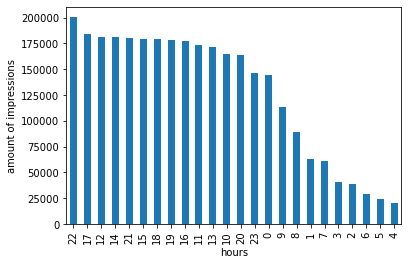

In [14]:
# amount of impressions group by hours


plt.figure(1)
df_bid_train[df_bid_train['click']==1].hour.value_counts().sort_index(axis=0,  kind='quicksort').plot(kind='bar') 
plt.ylabel('amount of clicks')
plt.xlabel('hours')
plt.figure(2)
df_bid_train[df_bid_train['click']==0].hour.value_counts().sort_index(axis=0,  kind='quicksort').plot(kind='bar') 
plt.ylabel('amount of impressions')
plt.xlabel('hours')

plt.show()

# the click amount rises and falls among time obviously， for example at 12 ,17 and 21 o'clock, user are more active to click the ads

In [55]:
# distribution of payprice

CPC_mean=df_bid_train[df_bid_train['click']==1].payprice.mean()
CPM_mean=df_bid_train[df_bid_train['click']==0].payprice.mean()
print("the mean payprice for click is:{}\nthe mean payprice for unclick is: {} ".format(CPC_mean,CPM_mean))

plt.figure(1)
df_bid_train[df_bid_train['click']==1].payprice.plot(kind='box', showfliers=False) 

plt.figure(2)
df_bid_train[df_bid_train['click']==0].payprice.plot(kind='box', showfliers=False) 

plt.show()
# the average costs: CPC (if clicked), CPM (if not clicked) 
CPC_mean=df_bid_train[df_bid_train['click']==1].payprice.mean()
CPM_mean=df_bid_train[df_bid_train['click']==0].payprice.mean()
print("the mean payprice for click is:{}\nthe mean payprice for unclick is: {} ".format(CPC_mean,CPM_mean))

,impression amount
android,19854
chrome,926578
firefox,22853
ie,2003772
ios,509
linux,1740
mac,64824
maxthon,7675
opera,3226
other,33685


## Preprocessing the dataset

### additional variable min 

As we mentioned before, each 15 min interval represents a time step in the DRLB framework. Therefore, we extract minute interval with values ["00","15","30","45"] from timestamp as an additional variable "min". 

In [ ]:
# add the min intervals

def get_time_interval(data):
    time_inv=int(data[10:12])
    if time_inv>=0 and time_inv<15:
            return ("00")
    elif time_inv >= 15 and time_inv < 30:
            return ("15")
    elif time_inv >= 30 and time_inv < 45:
            return ("30")
    elif time_inv >= 45 and time_inv <=60:
            return ("45")
    else:
            return(None)

if 'min' in df_bid_train.columns:
    print("min already exists")
    pass
else:
    df_bid_train["timestamp"]=df_bid_train["timestamp"].apply(str)
    min_intervals = df_bid_train.apply(lambda row : get_time_interval(row['timestamp']), axis = 1)
    df_bid_train.insert(3, "min", min_intervals) # insert the new column after the 'hour' column
    # save the updated dataset
    # df_bid_train.to_csv('data/ipinyou/1458/train.log.txt', sep="\t", header=True, index=False)

 ### logistic regression for CTR
 
 The following briefly explains the preprocessing of the train data to obtain the predicted CTRs which is based on the click of the train set as our target variable.   

To estimate the CTR and therefore to predict the probability of a user to click on an ad impression, we apply the logistic regression model as our prediction model. In the logistic regression models most of our features are dummies. Thus, most of these features we converted into categorical features first and then transformed them into dummy variables.

Also, we briefly want to highlight some of the (dummy) feature transformations more in detail. From user agent we exctracted the browser and operation systems. User tags are processed to extract the tag list of each user. According to Zhang et al. (2014) the weekday and hour feature are extracted from the timestamps. As mentioned earlier, we additionally extracted time intervals for every quarter points of an hour in minutes. Furthermore, region, city, ad slot width, height, visibility, format, ad exchange are processed in the logistic regression model as dummy variables and the ad slot floor price as numeric. In total, we have 312 binary features for the logistic regression model.   
Overall, we included features, which are quite generic and not fixed or unique values such as IDs, URLs or paying price.   

In the logistic regression model the default of L2 regularization is used. Also, we want to emphasize that a significant imbalance of 0 (no clicks) and 1 (clicks) values exists in the target variable. Hence, we balanced the minority class 1 by using the class_weight parameter of the logistic regression function.

In [24]:
from sklearn.metrics import roc_auc_score
print("pCTR AUC in the train set: ", roc_auc_score(df_bid_train['click'], df_bid_train['pCTR']))
print("pCTR AUC in the test set: ", roc_auc_score(df_bid_test['click'], df_bid_test['pCTR']))

pCTR AUC in the train set:  0.9452306887829061
pCTR AUC in the test set:  0.9735301800409389


Surprisingly, our prediction model yields a very high prediction accuracy, and especially interesting is the fact the AUC in the test set is higher than in the train set. We double-checked our logistic regression and implementation and couldnt't find any data leakage from the test set or the target into the fitted model.  
We assume that the high prediction value results from the user tag variable. The user tag variable basically is the segmentation of users into different groups according to heterogeneous features within the group and targeting each group with ads. User segmentation can be quite important for predicting the user behavior response on ads. Different CTRs can be received on different user tags. 

In [ ]:
##training Logitstic Regression model and predict the CTR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import joblib


class Logistic_Regression():
    
    # The dummified datasets is not proviuded, due to their big size (>5GB)
    df_bid_requests=pd.read_csv(".../dummified_train_test.txt", sep="\t")
    df_bid_test=pd.read_csv("...//dummified_test_test.txt", sep="\t")
    
    #training

    df_bid_test=pd.DataFrame(df_bid_test.astype(np.uint8))
    df_bid_requests=pd.DataFrame(df_bid_requests.astype(np.uint8))

    X = df_bid_requests.drop(['click','slotprice'], axis=1)
    Y = df_bid_requests.click
    df_bid_test=df_bid_test.drop(['slotprice'],axis=1)

    #df_bid_test = df_bid_test[np.intersect1d(X.columns, df_bid_test.columns)]

    X=X[np.intersect1d(X.columns, df_bid_test.columns)]

############ Train model with Logitstic Regression
    #Logistic Regression: Model fitting
    
    logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
    logreg.fit(X, Y)

    #save models
    joblib_filename = "logreg.sav"
    joblib.dump(logreg, joblib_filename)


    # Check auccuracy score
    print(logreg.score(X,Y))
    prob = logreg.predict_proba(X)[:, 1]
    print(roc_auc_score(Y, prob))

    logreg = joblib.load("logreg.sav")
    #
    # # ## Logistic Regression: Predict CTR
    ctr_pre_train=logreg.predict(X)
    ctr_pre_train_proba=logreg.predict_proba(X)
    df_ctr_train = pd.DataFrame(ctr_pre_train_proba, columns=['ctr_prediction_pro','ctr_prediction'])
    df_ctr_train['click'] =ctr_pre_train
    df_ctr_train.to_csv('.../ctr_pred_train.txt', index=False, sep='\t', header=True)

    ctr_pred = logreg.predict(df_bid_test[X.columns])
    ctr_pre_proba = logreg.predict_proba(df_bid_test[X.columns])


    df_ctr_test = pd.DataFrame(ctr_pre_proba, columns=['ctr_prediction_pro_0', 'ctr_prediction_pro_1'])
    df_ctr_test['click']=ctr_pred
    print(df_bid_test)
    df_ctr_test.to_csv('.../ctr_pred_test.txt',
                         index=False, sep='\t', header=True)

# 5. DRLB Implementation

Since the implementation of DRLB was not made public by the authors, we had to code it on our own. Although we've found [one implementation](https://github.com/venkatacrc/Budget_Constrained_Bidding) of DRLB on Github, it is missing some functionality that was introduced in the paper, and, to be honest, has some parts that are flat out wrongly implemented. Therefore, even though this code was very useful as a skeleton to base our implementation on, we've added a lot of fixes and improvements to it. 

Since the codebase is quite large to use directly in the notebook, we'll include here only some important parts. Let's first start by looking at how each state $s_t$ state in the (episodic) CMDP formulated for the RTB problem is defined. Remember, one episode is represented by one day in the iPinYou data, while one time step is equal to a 15 min interval:

In [ ]:
def _get_state(self):
    """
    Returns the state that will be used as input in the DQN
    """
    return np.asarray([self.t_step, # 1. Current time step
            self.rem_budget, # 2. the remaining budget at time step t
            self.ROL, # 3. The number of Lambda regulation opportunities left in the episode (amount of time steps left)
            self.BCR, # 4. Budget consumption rate: (Bt - Bt-1)/Bt
            self.CPM, # 5. Cost per mille of impressions between t-1 and t: (costs at t/impressions at t)*1000
            self.WR, # 6. Auction win rate at state t: (won impressions at t)/(total bidding opportunities at t)
            self.rewards_prev_t]) # 7. Total clicks on the ad placements we've won at t-1

Next, let's see how the bidding agent that acts in our problem's environment, based on the states that it receives, is initialized:

In [ ]:
class RlBidAgent():
    
    def __init__(self):
        # Beta parameter adjusting lambda, that regulates the agent's bid amount
        self.BETA = [-0.08, -0.03, -0.01, 0, 0.01, 0.03, 0.08]
        # Starting value of epsilon in the adaptive epsilon-greedy policy
        self.eps = 0.9
        # Parameter controlling the annealing speed of epsilon, suggested by Wu et al. (2018)
        self.anneal = 2e-5
        # DQN Network to learn Q function
        self.dqn_agent = DQN(state_size = 7, action_size = len(self.BETA))
        # Reward Network to learn the reward function
        self.reward_net = RewardNet(state_action_size = len(self.BETA) + 1, reward_size = 1)
        # Number of timesteps in each episode (4 15min intervals x 24 hours = 96), as formulated by Wu et al. (2018)
        self.T = 96
        # Initialize the DQN action for t=0 (index 3 - no adjustment of lambda, 0 in self.BETA)
        self.dqn_action = 3

The first beta parameter is basically all the actions that the DQN is able to take at each time step to control the lambda parameter, thus corresponding to the action size (i.e. the output layer) of the DQN. It outputs the distribution of Q values over all actions, so e.g. if the highest Q value is at index 3 of the output layer, the bidding agent adjusts lambda by 0 percent:

$$ \lambda_{t-1} = \lambda_t \times (1 + \beta_a). $$

The RewardNet takes the state-action pair as input, while outputting one reward value. Both networks consist of 3 hidden layers with 100 neurons in each layer and ReLU activation functions. Here's how each of the networks is initialized:

In [ ]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 1.0             # discount factor
LR = 1e-3               # learning rate 
C = 100                 # how often to update the network

class DQN():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.

            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        set_seed()

        # Q-Network
        self.qnetwork_local = Network(state_size, action_size).to(device)
        self.qnetwork_target = Network(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.criterion = nn.MSELoss()

        # Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, 0)

The reason for using two differnet instantiations of the Q network simultaneously was explained by Minh et al. (2015), who introduced the DQN itself. Every $C$ updates the `qnetwork_local` is cloned to obtain `qnetwork_target`, which is used for generating the Q-learning targets $y$ for the following $C$ updates to `qnetwork_local`. This makes the algorithm more stable, since generating the targets using an older set of parameters adds a delay between the time an update to `qnetwork_local` is made and the time the update affects the targets $y$, making divergence or oscillations of the learned policy much more unlikely. The input to the `qnetwork_local` is the current state $s_t$, while the `qnetwork_target` receives state $s_{t+1}$ as input.

To get an intuitive understanding for why the targets for predictions of the DQN for $s_t$ are predictions of (almost) the same DQN for $s_{t+1}$, think about it as a way to peek into the future using all available resources at the current time step. Maybe knowing how the DQN performs an update of its parameters will aid in understanding this idea a bit better:

In [ ]:
def learn(self, experiences, gamma, terminal):
        """Update value parameters using given batch of experience tuples.

            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s') tuples 
            gamma (float): discount factor, always equal to 1 in DRLB
        """
        states, actions, rewards, next_states = experiences

        if terminal == 1: # if the next state is the last one in the episode
            y = rewards
        else:
            y = rewards + gamma * self.qnetwork_target(next_states).max(1, keepdim=True)[0] # calculate best actions for each of the 32 s_t+1

        # Get Q values from local model
        Q_local = self.qnetwork_local(states).gather(1, actions) # get the Q values of the current DQN for the hsitorical actions taken

        # Compute loss
        loss = self.criterion(Q_local, y)
        print("DQN loss = {}".format(loss))
        # Grad descent
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.loss = loss.item()
        # Every C steps reset Q target = Q (hard copy)
        if ((self.t_step + 1) % C) == 0:
            for target_param, local_param in zip(self.qnetwork_target.parameters(), self.qnetwork_local.parameters()):
                target_param.data.copy_(local_param.data)

Every $C=100$ steps the DQN samples a mini-batch containing 32 of each (corresponding to each other) $s_t$, $s_{t+1}$, $r_t$ and $a_t$ from its replay memory (initialzied above with maximum length of 100 000 records/states). So, the action of DQN in state $s_t$ is evaluated based on the action that it would take at the next step $s_{t+1}$, based on the reward for the action at the current step. And this chain can be unfolded for each time step, except for the last one in the episode. 

The gamma parameter is always set to 1 in DRLB, since the optimization goal of the budget constrained bidding problem is to maximize the total reward value under the cost constraint regardless of the reward time (i.e. we don't want to punnish getting clicks on the won ad placements later in the episode).

But how does the DQN decide on which actions to make?

In [25]:
def act(self, state, eps, eval_flag):
        """Returns actions for given state as per current policy.

            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)[0] # [0] 'cause otherwise nested array
        self.qnetwork_local.train()

        if eval_flag == 0:
            # Epsilon-greedy action selection
            # Check if the Q-value distribution is unimodal, if so:
            if self.unimodal_check(action_values) == True:
                if random.random() <= eps:
                    # choose action randomly with prob epsilon
                    return random.choice(np.arange(self.action_size))
                else: # and a regular action with 1-eps
                    return np.argmax(action_values.cpu().data.numpy())
            # If not unimodal, increase epsilon, if it's small
            else:
                prob = max(eps, 0.5)
                if random.random() <= prob:
                    return random.choice(np.arange(self.action_size))
                else: # and with 1-p choose an action regularly 
                    return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.argmax(action_values.cpu().data.numpy())

The unimodality check of the action-value distribution $Q(s_t, a_t)$, was proposed by the authors of DRLB - theyu believe that when the distribution is not unimodal, the current estimation of Q is abnormal and the $\epsilon$ should be increased to encourage more explorations under this state. The following figure taken from the DRLB paper illustrates the unimodal (normal) vs abnormal distribution. The unimodality check is done using a simple heuristic test.

<img src="img/Q_distribution.png" width=750 height=750 />

Below are the full training algorithms of the DQN and the RewardNet. The training process of the RewardNet is much simpler, since it simply learns to predict an optimal reward for a given state-action pair.

<img src="img/DRLB.png" width=900 height=900 />

The $\lambda_0$ at the beginning of each episode is calculated by solving the bidding problem as a knapsack problem using the greedy approximation algorithm introduced by Dantzig (1957).

In [ ]:
def calc_greedy(items, budget_limit):
    # Borrowed from: https://bitbucket.org/trebsirk/algorithms/src/master/knapsack.py
    bids = []
    spending = 0
    ctr = 0
    items_sorted = sorted(items, key=itemgetter(2), reverse=True) # sort bid requests by pCTR/payprice
    while len(items_sorted) > 0:
        item = items_sorted.pop()
        if item[0] + spending <= budget_limit:
            bids.append(item)
            spending += bids[-1][1]
            ctr += bids[-1][0]
        else:
            break
    ctrs = np.array(bids)[:,0]
    costs = np.array(bids)[:,1]
    # Take the max lambda to be more conservative at the beginning of a time step
    opt_lambda = np.max(np.divide(ctrs, costs))
    return opt_lambda

## Training DRLB

Since neither Wu et al. (2018), nor Cai et al. (2017), against whose framework the former compared DRLB, provide a budget constraint during training, we decided to initialize the budget for each episode as the total cost of the auction (sum of all payprices) divided by 4 and split into 7 equal parts. We thought that this may be a good balance between giving an agent enough money play around with, while also being cosntrained enough.

Warning: the DRLB takes a long time, therefore we commented out the training code, so you don't accidentally run this cell.

In [ ]:
# # Train DRLB

# import sys  
# import torch
# import cloudpickle
# sys.path.insert(0, 'src/rtb_agent')
# from rl_bid_agent import RlBidAgent
# from model import set_seed
# import gym, gym_auction_emulator

# #Instantiate the Environment and Agent
# env = gym.make('AuctionEmulator-v0')
# env.seed(0)
# set_seed()
# agent = RlBidAgent()

# epochs = 200

# for epoch in range(epochs):

#     print("Epoch: ", epoch+1)

#     obs, done = env.reset()
#     train_budget = env.bid_requests.payprice.sum()/4
#     # Set budgets for each episode
#     budget_proportions = []
#     for episode in env.bid_requests.weekday.unique():
#         budget_proportions.append(len(env.bid_requests[env.bid_requests.weekday == episode])/env.total_bids)
#     for i in range(len(budget_proportions)):
#         budget_proportions[i] = round(train_budget * budget_proportions[i])
#     agent.episode_budgets = budget_proportions
    
#     agent._reset_episode()
#     agent.cur_day = obs['weekday']
#     agent.cur_hour = obs['hour']
#     agent.cur_state = agent._get_state() # observe state s_0

#     while not done: # iterate through the whole dataset
#         bid = agent.act(obs) # Call agent action given each bid request from the env
#         next_obs, cur_reward, cur_cost, win, done = env.step(bid) # Get information from the environment based on the agent's action
#         agent._update_reward_cost(bid, cur_reward, cur_cost, win) # Agent receives reward and cost from the environment
#         obs = next_obs
#     print("Episode Result with Step={} Budget={} Spend={} wins={} rewards={}".format(agent.global_T, agent.budget, agent.budget_spent_e, agent.wins_e, agent.rewards_e))
#     agent.episode_memory.append([agent.budget, agent.budget_spent_e, agent.wins_e, agent.rewards_e])

#     # Saving models and history
#     if ((epoch + 1) % 10) == 0:
#         PATH = 'models/model_state_{}.tar'.format(epoch+1)
#         torch.save({'local_q_model': agent.dqn_agent.qnetwork_local.state_dict(),
#                     'target_q_model':agent.dqn_agent.qnetwork_target.state_dict(),
#                     'q_optimizer':agent.dqn_agent.optimizer.state_dict(),
#                     'rnet': agent.reward_net.reward_net.state_dict(),
#                     'rnet_optimizer': agent.reward_net.optimizer.state_dict()}, PATH)

#         f = open('models/rnet_memory_{}.txt'.format(epoch+1), "wb")
#         cloudpickle.dump(agent.dqn_agent.memory, f)
#         f.close()
#         f = open('models/rdqn_memory_{}.txt'.format(epoch+1), "wb")
#         cloudpickle.dump(agent.reward_net.memory, f)
#         f.close()

#         pd.DataFrame(agent.step_memory).to_csv('models/step_history_{}.csv'.format(epoch+1),header=None,index=False)
#         agent.step_memory=[]
#         pd.DataFrame(agent.episode_memory).to_csv('models/episode_history_{}.csv'.format(epoch+1),header=None,index=False)
#         agent.episode_memory=[]

#     print("EPOCH ENDED")

# env.close() # Close the environment when done

## Baseline: Random Bidding

As a baseline for our DRLB implementation we decided to first use just simple random uniform bidding. As a budget constraint Cai et al. (2017) provide the following calculation:

$$B = CPM_{train} \times 10^{-3} \times T \times c_0$$

where $CPM_{train}$ is the cost per mille of impressions in the training data, $T$ is the amount of steps in each episode and $c_0$ acts as the budget constraint parameter. Following their work, we set multiple values of $c_0$ = 1/32, 1/16, 1/8, 1/4, 1/2.

In [2]:
#load the datasets
import pandas as pd
bid_requests_train = pd.read_csv('data/ipinyou/1458/train.log.txt', sep="\t")
bid_requests_test = pd.read_csv('data/ipinyou/1458/test.log.txt', sep="\t")

In [93]:
# define budget for each episode according to (Cai et al., 2017)
CPM_train = 1000 * (bid_requests_train.payprice.sum()/len(bid_requests_train))
budget = CPM_train * (10**-3) * 96
episode_budgets = [budget/2,budget/4,budget/8,budget/16,budget/32]
bid_random = bid_requests_test
bid_budget = pd.DataFrame()
bid_budget['bugdet']=episode_budgets
bid_budget['portion']=['1/2','1/4','1/8','1/16','1/32']
bid_budget.round()

,bugdet,portion
0,3307.0,1/2
1,1653.0,1/4
2,827.0,1/8
3,413.0,1/16
4,207.0,1/32


In [94]:
# Random Bidding
import pandas as pd
import numpy as np
import random
random.seed(0)
np.random.seed(0)

# create a temporary dataframe
c_names=('click','day', 'slotprice', 'payprice','r_bid_amt','wins')
zero_Data=np.zeros(shape=(len(bid_requests_test),len(c_names)))
df=pd.DataFrame(zero_Data,columns=c_names)
df['day']=bid_requests_test['weekday']
df['click']=bid_requests_test['click']
df['slotprice'] = bid_requests_test['slotprice']
df['payprice'] = bid_requests_test['payprice']
# generate random bids for each bid request, no higher than the bids of other auction participants
df['r_bid_amt']=np.random.randint(0,bid_requests_test['payprice'].max(),len(bid_requests_test))

i = 1
for budget in episode_budgets:
    for day in df['day'].unique(): # for each episode
        episode = df[df['day'] == day].copy(deep = True) # get an episode subset from the whole test set
        rem_budget = budget # and set the budget
        while rem_budget > 0: # while the budget is not exhausted
            bid_request = episode.sample() # sample a random bid request
            if bid_request['r_bid_amt'].values[0] > bid_request['payprice'].values[0]:
                index = bid_request.index[0]
                episode = episode.drop(episode.loc[episode.index == index].index[0]) # remove bid request if we win the auction
                df.loc[index, 'wins'] = i # track which budget won the auction
                # adjust the budget accordingly
                rem_budget = rem_budget - max(bid_request['payprice'].values[0], bid_request['slotprice'].values[0])
                # stop if not possible to win anything anymore
                if rem_budget <= episode['payprice'].min():
                    rem_budget = 0
    i += 1

In [95]:
rand_clicks = []
rand_imps = []
for i in range (4,7):
    for j in range(1,6):
        rand_clicks.append(df[(df['wins'] == j) & (df['day'] == i)]['click'].sum())
        rand_imps.append(len(df[(df['wins'] == j) & (df['day'] == i)]))

In [99]:
# Display the results of random bidding

interables=[['clicks','impression'],['1/2','1/4','1/8','1/16','1/32']]
arrays=pd.MultiIndex.from_product(interables, names=['reward', 'portion'])
a=pd.Series(rand_clicks[:5] + rand_imps[:5])
b=pd.Series(rand_clicks[5:10] + rand_imps[5:10])
c=pd.Series(rand_clicks[10:] + rand_imps[10:])
display=pd.DataFrame(pd.concat([a,b,c],axis=1).values, index=arrays)
display.columns=["day 8","day 9","day 10"]
print("Results of random bidding on the test set:")
display

Results of random bidding on the test set:


day 8  day 9  day 10
reward     portion                      
clicks     1/2          0      0       0
           1/4          0      0       0
           1/8          0      0       0
           1/16         0      0       0
           1/32         0      0       0
impression 1/2         61     59      63
           1/4         32     30      29
           1/8          9     14      15
           1/16         7      6       5
           1/32         3      4       3

# 6. DRLB Results

We've trained the DRLB for approx. 200.000 time steps. Wu et al. (2018) suggested at least 125.000 and ideally 250.000 time steps. Let's take a look at how the trained model bids on the test set.

In [3]:
import sys
import torch
import cloudpickle
sys.path.insert(0, 'src/rtb_agent')
from rl_bid_agent import RlBidAgent
from model import set_seed
import gym, gym_auction_emulator
import pandas as pd

env = gym.make('AuctionEmulator-v0')
env.seed(0)

bid_requests_train = pd.read_csv('data/ipinyou/1458/train.log.txt', sep="\t")

# Calculate lambda_0 for the first episode in the test set
last_train_episode = bid_requests_train[bid_requests_train['weekday'] == 6]
items = []
for obs in last_train_episode.values:
    items.append([obs[1], obs[25], obs[1]/max(obs[25], 1)])

# Set the budgets for each episode according to Cai et al. (2017)
CPM_train = 1000 * (bid_requests_train.payprice.sum()/len(bid_requests_train))
budget = CPM_train * (10**-3) * 96
eval_budgets = [budget/2,budget/4,budget/8,budget/16,budget/32]

for e_budget in eval_budgets:

    # Initialize the bidding agent
    set_seed()
    agent = RlBidAgent()

    # Load the saved models
    checkpoint = torch.load('models/model_state_40.tar')
    agent.dqn_agent.qnetwork_local.load_state_dict(checkpoint['local_q_model'])
    agent.dqn_agent.optimizer.load_state_dict(checkpoint['q_optimizer'])
    agent.reward_net.reward_net.load_state_dict(checkpoint['rnet'])
    agent.reward_net.optimizer.load_state_dict(checkpoint['rnet_optimizer'])

    # init the current budget for each episode
    agent.episode_budgets = [e_budget, e_budget, e_budget]

    # start evaluating
    obs, done = env.reset()
    agent._reset_episode()
    agent.ctl_lambda = agent.calc_greedy(items, e_budget)
    agent.cur_day = obs['weekday']
    agent.cur_hour = obs['hour']
    agent.cur_state = agent._get_state() # observe state s_0

    while not done: # iterate through the whole dataset
        bid = agent.eval_act(obs) # Call agent action given each bid request from the env
        next_obs, cur_reward, cur_cost, win, done = env.step(bid) # Get information from the environment based on the agent's action
        agent._update_reward_cost(bid, cur_reward, cur_cost, win) # Agent receives reward and cost from the environment
        obs = next_obs
    print("Episode Result with Step={} Budget={} Spend={} impressions={} clicks={}".format(agent.global_T, agent.budget, agent.budget_spent_e, agent.wins_e, agent.rewards_e))

env.close()

Episode Result with Step=95 Budget=3306.8525411150495 Spend=3306.8525411150495 wins=1 rewards=0
Episode Result with Step=189 Budget=3306.8525411150495 Spend=3306.8525411150495 wins=1 rewards=0
Episode Result with Step=283 Budget=3306.8525411150495 Spend=3306.8525411150495 impressions=1 clicks=0
Episode Result with Step=95 Budget=1653.4262705575247 Spend=1653.4262705575247 wins=1 rewards=0
Episode Result with Step=189 Budget=1653.4262705575247 Spend=1653.4262705575247 wins=1 rewards=0
Episode Result with Step=283 Budget=1653.4262705575247 Spend=1653.4262705575247 impressions=1 clicks=0
Episode Result with Step=95 Budget=826.7131352787624 Spend=826.7131352787624 wins=1 rewards=0
Episode Result with Step=189 Budget=826.7131352787624 Spend=826.7131352787624 wins=1 rewards=0
Episode Result with Step=283 Budget=826.7131352787624 Spend=826.7131352787624 impressions=1 clicks=0
Episode Result with Step=95 Budget=413.3565676393812 Spend=413.3565676393812 wins=1 rewards=0
Episode Result with Step

Unfortunately, the performance of the DRLB is unsatisfiable to say the least. Basically the agent spends all its money on the first bid request it sees (and obviously wins it). Teh fact that we've trained the model for approx. 200.000 time steps (Wu et al. suggested at least 125.000 and ideally 250.000) tells us that the subpar results most likely stem not from the fact that the model wasn't trained long enough, but rather from some other weak part of the model.

As a reminder, at the beginning of each episode the $\lambda_0$ parameter is set as the result of solving the knapsack problem of the previouis episode with the greedy aproximation algorithm. Even by taking the highest lambda produced by that algorithm (which leads to lower bids), that lambda still produces much higher bids than the market price on a given ad placement, which leads to a very high spending in the first time step.

To analyze this further, taking a look at the training history is necessary.

In [12]:
# Import history of the first 25 epochs
history1 = pd.read_csv('models/step_history_25.csv', names=['global_T', 'rem_budget', 'ctl_lambda', 'eps', 
                                                           'dqn_action', 'dqn_agent_loss', 'rnet_r', 
                                                           'reward_net_loss'])
# Subset the last training episode from the 10th epoch
last_train_episode_10 = history1[history1['global_T']>=16259].copy()
last_train_episode_10 = last_train_episode_10.reset_index(drop=True)

# Import history of the last 25 epochs
history2 = pd.read_csv('models/step_history_300.csv', names=['global_T', 'rem_budget', 'ctl_lambda', 'eps', 
                                                           'dqn_action', 'dqn_agent_loss', 'rnet_r', 
                                                           'reward_net_loss'])
# Subset the very last training episode
last_train_episode = history2[history2['global_T']>=196109].copy()
last_train_episode = last_train_episode.reset_index(drop=True)
last_train_episode

,global_T,rem_budget,ctl_lambda,eps,dqn_action,dqn_agent_loss,rnet_r,reward_net_loss
0,196109,4630614.86,0.000683,0.05,5,7.341998e+06,25.252375,2.466341
1,196110,3654836.63,0.000738,0.05,6,1.437010e+05,20.194681,0.223770
2,196111,3240797.59,0.000797,0.05,6,1.188465e+04,20.194698,0.796758
3,196112,2710508.32,0.000860,0.05,6,1.085120e+08,20.200081,3.149099
4,196113,2246655.13,0.000886,0.05,5,4.880028e+06,20.217422,2.191170
...,...,...,...,...,...,...,...,...
87,196196,0.00,0.000590,0.05,2,2.049824e+07,26.953224,3.222082
88,196197,0.00,0.000572,0.05,1,4.409173e+06,26.988413,0.328590
89,196198,0.00,0.000555,0.05,1,2.046061e+03,27.015406,1.382332
90,196199,0.00,0.000510,0.05,0,3.612428e+07,26.984053,0.185301


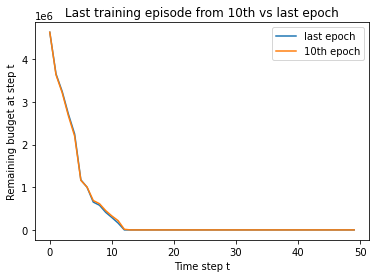

In [22]:
# Plot the budget spending at the last episode of training
ax = last_train_episode['rem_budget'].head(50).plot()
ax = last_train_episode_10['rem_budget'].head(50).plot()
ax.set_xlabel("Time step t")
ax.set_ylabel("Remaining budget at step t")
ax.set_title("Last training episode from 10th vs last epoch")
ax.legend(['last epoch', '10th epoch'])

From the graph above it seems obvious that the starting $\lambda_0$ is too high, since there is a very sharp drop in the remaining budget in the first 10 steps (out of 96) in both subsets of the training history. Basically because of that the model is not able to learn properly, i.e. learn to spend the budget under given constraints. We strongly believe that trying out different solutions for setting $\lambda_0$ should be considered as a potential improvement of the DRLB. 

The graph below shows that the DQN was making sensible steps in adjusting the $\lambda$ parameter by increasing it for the first 10 steps, which reinforces our suspicions about the $\lambda_0$. Once the agent exhausted its budget though, the DQN actions obviously cannot be evaluated properly.

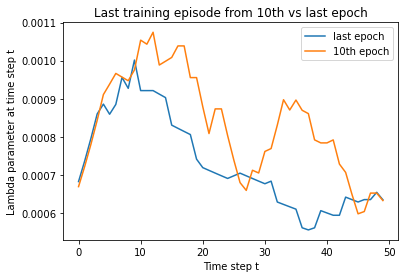

In [23]:
# Plot the lambda parameters in the last training episode
ax = last_train_episode['ctl_lambda'].head(50).plot()
ax = last_train_episode_10['ctl_lambda'].head(50).plot()
ax.set_xlabel("Time step t")
ax.set_ylabel("Lambda parameter at time step t")
ax.set_title("Last training episode from 10th vs last epoch")
ax.legend(['last epoch', '10th epoch'])

# 7. References 

Altman E. (1999): „Constrained Markov decision processes“, CRC Press, Vol. 7.  

Dantzig G. 1957. Discrete-variable extremum problems. Operations research 5, 2 (1957), 266–288.

Han Cai, Kan Ren, Weinan Zhang, Kleanthis Malialis, Jun Wang, Yong Yu, and Defeng Guo. 2017. Real-Time Bidding by Reinforcement Learning in Display Advertising. In Proceedings of the Tenth ACM International Conference on Web
Search and Data Mining. ACM, 661–670.

Singh A. (2019): „Reinforcement Learning : Markov-Decision Process (Part 1)“, [online] https://towardsdatascience.com/introduction-to-reinforcement-learning-markov-decision-process-44c533ebf8da [08.12.2020].  

Stekolshchik R. (2020): „A pair of interrelated neural networks in Deep Q-Network“, [online] https://towardsdatascience.com/a-pair-of-interrelated-neural-networks-in-dqn-f0f58e09b3c4 [09.12.2020].

Richard S. and Andrew G. (2018): "Reinforcement Learning", The MIT Press,pp.1-6. 

Mnih V., Kavukcuoglu K., Silver D., Rusu A.A., Veness J.  Bellemare M., Graves A., Riedmiller M.A., Fidjeland A., Ostrovski G., Petersen S., Beattie C., Sadik A., Antonoglou I., King H., Kumaran D., Wierstra D., Legg S., Hassabis D. (2015): "Human-level control through deep reinforcement learning", Nature 518, 7540, pp. 529–533.

Reza R.A, Yingqian Z., Murat F. et al., A State Aggregation Approach for Solving Knapsack Problem with Deep Reinforcement Learning,Proceedings of Machine Learning Research 129:81–96, 2020

Wu D., Chen X., Yang X., et al. (2018): „Budget Constrained Bidding by model-free Reinforcement Learning in Display Advertising“, Association for Computing Machinery, 27, pp. 1443–1451.  

Zhang W., Yuan S., and Wang J. (2014): „Optimal Real-Time Bidding for Display Advertising“ Association for Computing Machinery, 20, pp. 1077–1086. 

Zhang W., Yuan S., Wang J. (2014): "Real-Time Bidding Benchmarking with iPinYou Dataset", arXiv:1407.7073 [cs.GT]. 

Zhang W., Ren K., and Wang J (2016): "Optimal real-time bidding frameworks discussion", arXiv:1602.01007. 

Zhou Y., Chakrabarty D., and Lukose R. (2008): „Budget constrained bidding in keyword auctions and online knapsack problems“, International Workshop on Internet and Network Economics, Springer, pp. 566–576.  


